In [2]:
import os                                               # for working with files
import numpy as np                                      # for numerical computationss
import pandas as pd                                     # for working with dataframes
import torch                                            # Pytorch module
import gc                                               # for garbage collection
import seaborn as sns
import matplotlib.pyplot as plt                         # for plotting informations on graph and images using tensors
import torch.nn as nn                                   # for creating  neural networks
from torch.utils.data import DataLoader                 # for dataloaders 
from PIL import Image                                   # for checking images
import torch.nn.functional as F                         # for functions for calculating loss
import torchvision.transforms as transforms             # for transforming images into tensors 
from torchvision.utils import make_grid                 # for data checking
from torchvision.datasets import ImageFolder            # for working with classes and images
import torchvision.models as models                     # for pretrained models
from torchsummary import summary                        # for getting the summary of our model
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from yellowbrick.style import set_palette

In [3]:
data_dir = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)

In [4]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

In [5]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

# setting the batch size
batch_size = 32

# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [6]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [9]:
predictions = []
ground_truths = []

# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
def training_step(model, batch):
    images, labels = batch
    out = model(images)                       # Generate predictions
    loss = F.cross_entropy(out, labels)       # Calculate loss
    return loss

def validation_step(model, batch):
    images, labels = batch
    out = model(images)                        # Generate prediction
    loss = F.cross_entropy(out, labels)        # Calculate loss
    acc = accuracy(out, labels)                # Calculate accuracy

    ## Saving predictions for the matrix confusion generation
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    predictions.extend(predicted.cpu().numpy())
    ground_truths.extend(labels.cpu().numpy())

    return {"val_loss": loss.detach(), "val_accuracy": acc}

def validation_epoch_end(outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

def epoch_end(epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [10]:
weights = torch.load("ResNet_34_plant-model-83.pth")
pretrained_model = models.resnet34(pretrained=True, weights=weights)

# freezing the layers
for param in pretrained_model.parameters():
    param.requires_grad = False

# changing the last layer
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, len(train.classes))

# moving the model to GPU
pretrained_model = to_device(pretrained_model, device)

# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(pretrained_model.cuda(), (INPUT_SHAPE)))

/home/daniel/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/daniel/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:08<00:00, 9.94MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [11]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)
        
    return history

In [12]:
%%time
history = [evaluate(pretrained_model, valid_dl)]
history

CPU times: user 15.4 s, sys: 46 s, total: 1min 1s
Wall time: 55.3 s


[{'val_loss': tensor(3.9546, device='cuda:0'), 'val_accuracy': tensor(0.0034)}]

In [13]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [14]:
%%time
history += fit_OneCycle(epochs, max_lr, pretrained_model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=1e-4, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.7205, val_loss: 0.4138, val_acc: 0.9009
Epoch [1], last_lr: 0.00000, train_loss: 0.2279, val_loss: 0.1445, val_acc: 0.9576
CPU times: user 3min, sys: 3min 38s, total: 6min 38s
Wall time: 5min 41s


In [15]:
# saving the model
PATH = './models/resnet34-pre-trained-plants.pth'  
torch.save(pretrained_model.state_dict(), PATH)

In [16]:
def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'].cpu().numpy() for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    sns.lineplot(data=lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

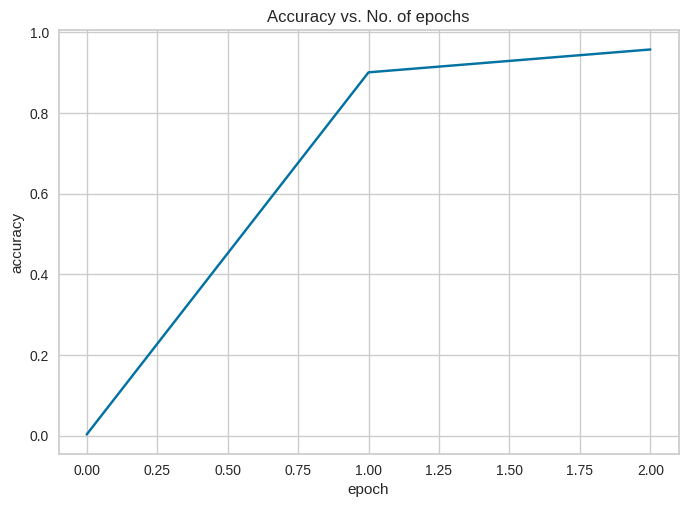

In [17]:
plot_accuracies(history)

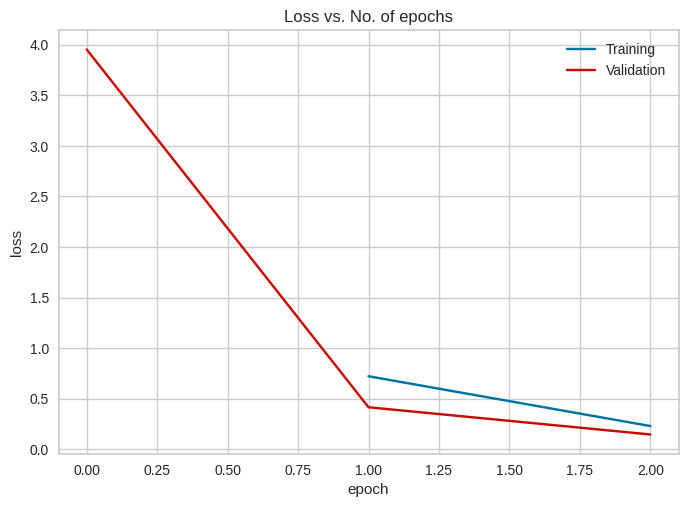

In [18]:
plot_losses(history)

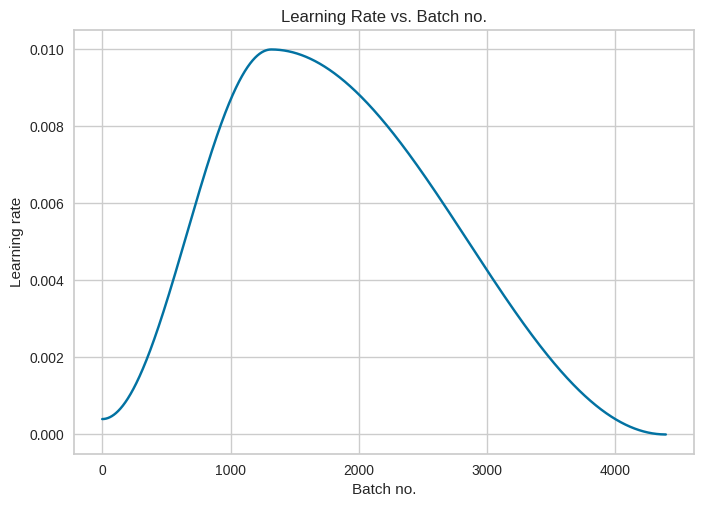

In [19]:
plot_lrs(history)

In [20]:
def obtain_performance_metrics(ground_truths, predictions):
    # Performance Metrics and Confusion Matrix
    print("Classification Report: ")
    print()
    target_names = train.classes
    print(classification_report(ground_truths, predictions, target_names=target_names))

    print("Balanced accuracy score: ")
    print(balanced_accuracy_score(ground_truths, predictions))

    print("\nConfusion Matrix: ")
    print()
    plt.figure(figsize=(20,20))
    matrix = confusion_matrix(ground_truths, predictions)
    sns.heatmap(matrix, cmap="PuBu", annot=True, linewidths=0.5, fmt= 'd')
    plt.show()


Classification Report: 

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.90      0.63      0.74      1512
                                 Apple___Black_rot       0.99      0.61      0.75      1491
                          Apple___Cedar_apple_rust       0.93      0.64      0.76      1320
                                   Apple___healthy       0.97      0.64      0.77      1506
                               Blueberry___healthy       0.97      0.63      0.76      1362
          Cherry_(including_sour)___Powdery_mildew       0.18      0.63      0.28      1263
                 Cherry_(including_sour)___healthy       0.92      0.66      0.77      1368
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.69      0.63      0.66      1230
                       Corn_(maize)___Common_rust_       0.50      0.62      0.56      1431
               Corn_(maize)___Northern_Leaf_Blight    

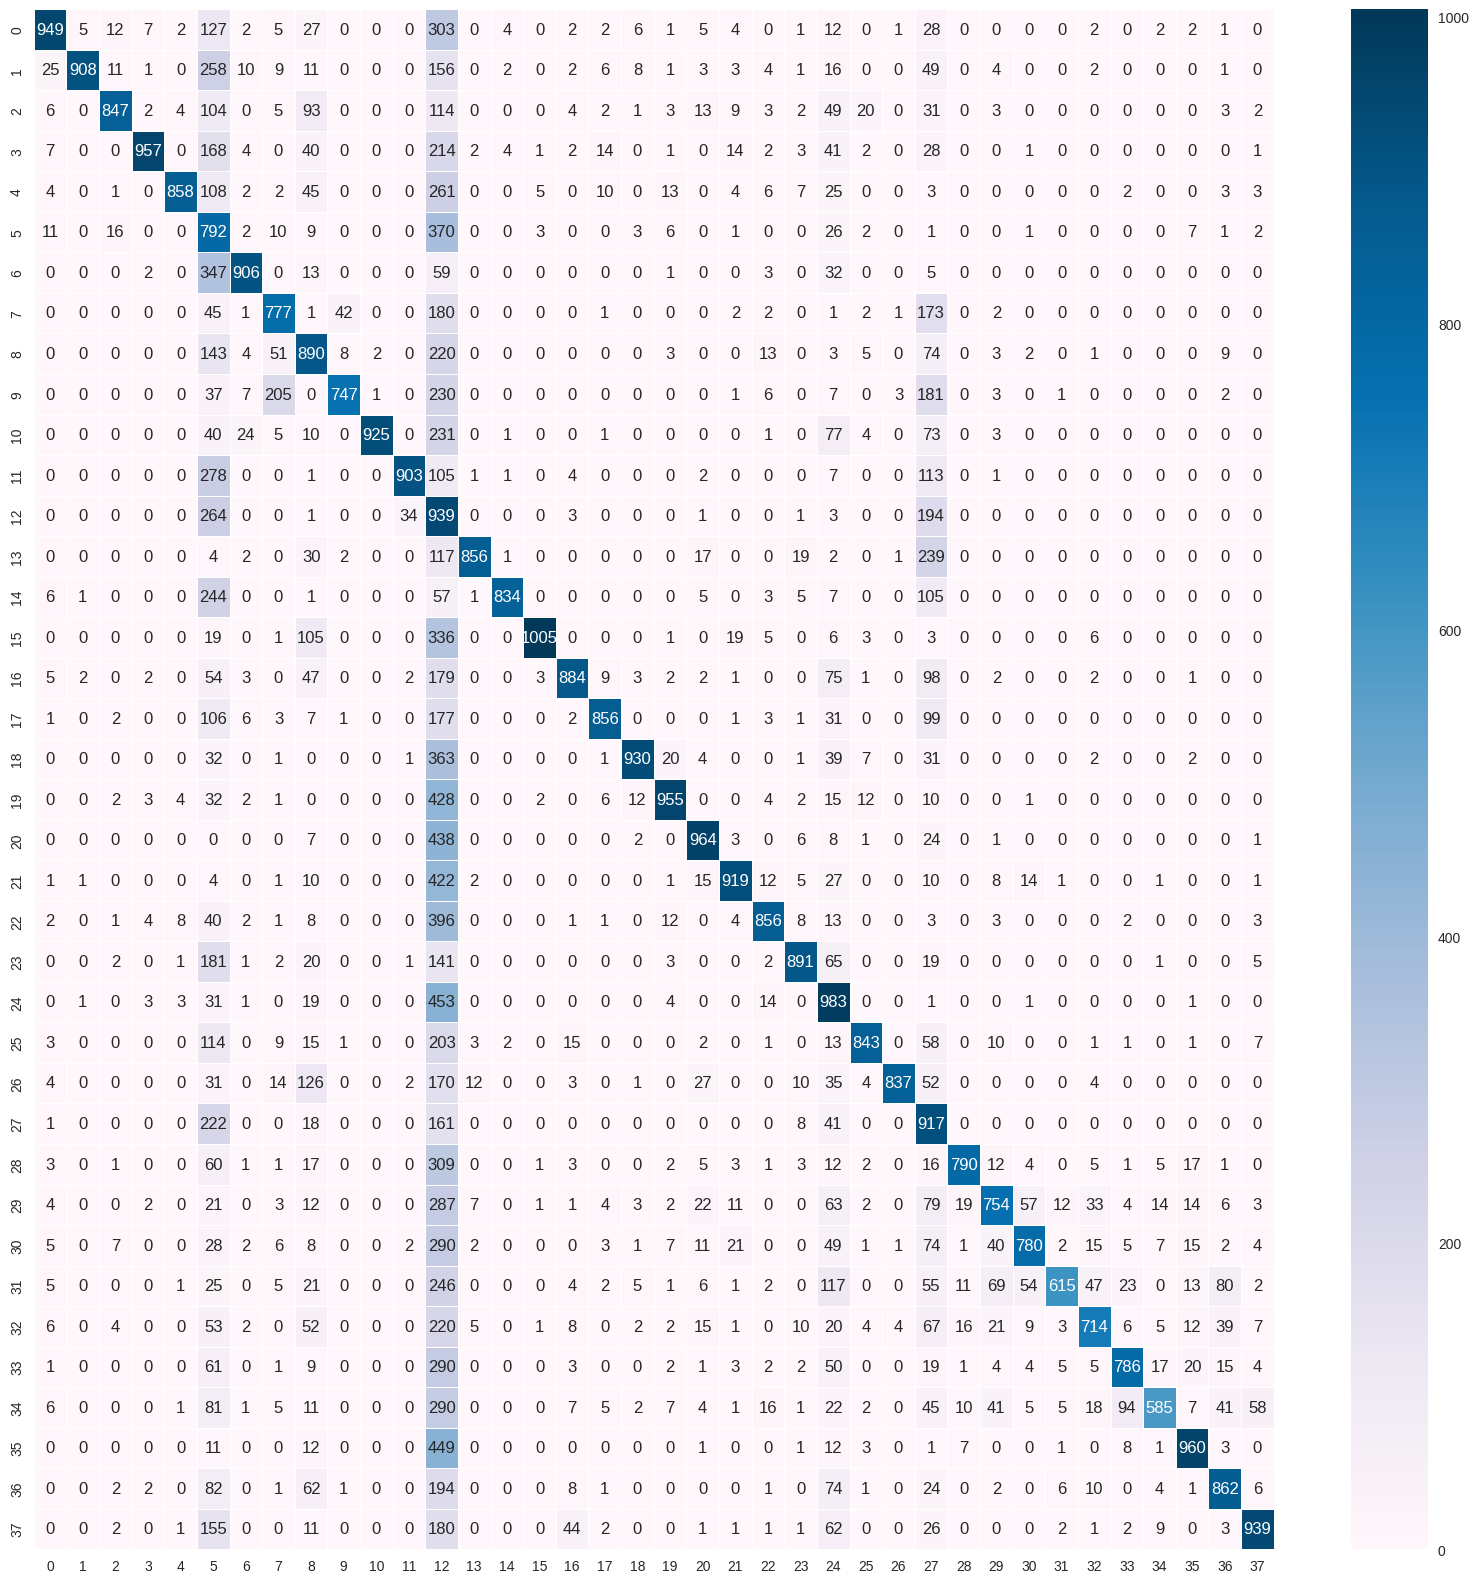

In [21]:
obtain_performance_metrics(ground_truths, predictions)